# Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from cv2 import cv2
from skimage import feature
from sklearn import neighbors


C:\Users\songy\miniconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\songy\miniconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Retrieve Dataset

In [3]:
from preprocess import retrieve_dataset, preprocess, to_np

(train_ds_raw, test_ds_raw), metadata = retrieve_dataset(should_shuffle_files=True)

train_ds = preprocess(train_ds_raw, {
  'is_undersample_negative': True,
  'reduce_dataset_to': 300,
  'is_grayscale': False, 
  'is_downsample64': False,
  'is_downsample128': False, 
  'is_normalize': False,
})

test_ds = preprocess(test_ds_raw, {
  'is_undersample_negative': True,
  'reduce_dataset_to': 75,
  'is_grayscale': False, 
  'is_downsample64': False, 
  'is_downsample128': False, 
  'is_normalize': False,
})

def count_class(counts, batch):
    labels = batch[1]
    for i in range(9):
        cc = tf.cast(labels == i, tf.int32)
        counts[i] += tf.reduce_sum(cc)
    return counts

initial_state = dict((i, 0) for i in range(9))
counts = train_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

print("Class breakdown for train dataset:")
print([(k, v.numpy()) for k, v in counts.items()])

initial_state = dict((i, 0) for i in range(9))
counts = test_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

print("Class breakdown for test dataset:")
print([(k, v.numpy()) for k, v in counts.items()])

Class breakdown for train dataset:
[(0, 29), (1, 44), (2, 21), (3, 31), (4, 37), (5, 34), (6, 36), (7, 38), (8, 30)]
Class breakdown for test dataset:
[(0, 10), (1, 11), (2, 6), (3, 4), (4, 5), (5, 13), (6, 13), (7, 8), (8, 5)]


# Extract X_train, Y_train, X_test, Y_test

In [4]:
train_ds_numpy = to_np(train_ds)
test_ds_numpy = to_np(test_ds)

In [5]:
X_train = [example for example, label in train_ds_numpy]
y_train = [label for example, label in train_ds_numpy]

X_test = [example for example, label in test_ds_numpy]
y_test = [label for example, label in test_ds_numpy]

# Visualize Preprocessed Dataset

Length of X_train: 300
Length of X_test: 75


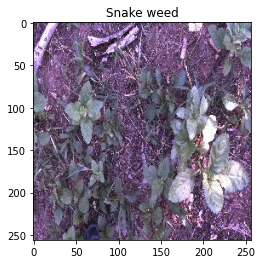

In [6]:
from visualize import visualize, compare

visualize(X_train[0], y_train[0], metadata)
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

# Perform Transfer Learning

In [7]:
from transfer_learning import init_conv_base, extract_features
conv_base = init_conv_base(X_train[0])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [8]:
train_features, train_labels = extract_features(conv_base, X_train, y_train)  # Agree with our small dataset size
test_features, test_labels = extract_features(conv_base, X_test, y_test)

# Flatten To Feed into KNN

In [9]:
X_train_flatten = list(map(lambda x: x.flatten(), train_features))
y_train = train_labels
X_test_flatten = list(map(lambda x: x.flatten(), test_features))
y_test = test_labels

print(train_labels.shape)
print("feature size now:", X_train[0].shape) # orginal feature is of dimension 196608

(300,)
feature size now: (256, 256, 3)


In [10]:
# For KNN, K Fold is just to look at prediction across various sets of data
X_full = list(X_train_flatten) + list(X_test_flatten)
y_full = list(y_train) + list(y_test)

print(len(X_full))
print(len(y_full))

375
375


# Test Model with K Fold Validation

In [11]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import kfold_cross_validation

In [12]:
n_neighbors_arr = [5, 10, 15, 20]
k = 5
clfs_and_accuracies = []

for n_neighbors in n_neighbors_arr:
  clf_and_accuracy = kfold_cross_validation(k, X_full, y_full, 'knn', {'n_neighbors': n_neighbors})
  clfs_and_accuracies.append(clf_and_accuracy)

Running 5-fold cross validation for knn with {'n_neighbors': 5}
Split accuracy: 0.29333333333333333
Split accuracy: 0.30666666666666664
Split accuracy: 0.4
Split accuracy: 0.30666666666666664
Split accuracy: 0.30666666666666664
Completed 5-fold cross validation for knn with {'n_neighbors': 5}
Obtained average accuracy of: 0.32266666666666666

Running 5-fold cross validation for knn with {'n_neighbors': 10}
Split accuracy: 0.29333333333333333
Split accuracy: 0.3466666666666667
Split accuracy: 0.4266666666666667
Split accuracy: 0.29333333333333333
Split accuracy: 0.37333333333333335
Completed 5-fold cross validation for knn with {'n_neighbors': 10}
Obtained average accuracy of: 0.3466666666666666

Running 5-fold cross validation for knn with {'n_neighbors': 15}
Split accuracy: 0.2
Split accuracy: 0.3333333333333333
Split accuracy: 0.38666666666666666
Split accuracy: 0.26666666666666666
Split accuracy: 0.4
Completed 5-fold cross validation for knn with {'n_neighbors': 15}
Obtained average

In [13]:
print(clfs_and_accuracies)

[(KNeighborsClassifier(), 0.4), (KNeighborsClassifier(n_neighbors=10), 0.4266666666666667), (KNeighborsClassifier(n_neighbors=15), 0.4), (KNeighborsClassifier(n_neighbors=20), 0.37333333333333335)]


In [14]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import get_precision_scores, get_roc_auc_curve, visualize_roc_auc_curve

In [15]:
for clf_and_accuracy in clfs_and_accuracies:
  (clf, accuracy) = clf_and_accuracy
  print(get_precision_scores(clf, X_full, y_full))

{'accuracy': 0.5306666666666666, 'macro_avg': 0.5965288228341633, 'f1_score_macro': 0.5122975341368885, 'micro_avg': 0.5306666666666666, 'f1_score_micro': 0.5306666666666666, 'roc_auc_score': 0.8910684677841747}
{'accuracy': 0.45066666666666666, 'macro_avg': 0.5522241474288644, 'f1_score_macro': 0.4255429261154452, 'micro_avg': 0.45066666666666666, 'f1_score_micro': 0.45066666666666666, 'roc_auc_score': 0.8703989906894386}
{'accuracy': 0.4, 'macro_avg': 0.45755556577925, 'f1_score_macro': 0.3646052840400017, 'micro_avg': 0.4, 'f1_score_micro': 0.41551246537396125, 'roc_auc_score': 0.8588093612556265}
{'accuracy': 0.376, 'macro_avg': 0.5114959633278598, 'f1_score_macro': 0.33689187043036695, 'micro_avg': 0.376, 'f1_score_micro': 0.3905817174515236, 'roc_auc_score': 0.8505886797335473}


In [16]:
fprs = []
tprs = []
roc_aucs = []
for clf_and_accuracy in clfs_and_accuracies:
  (fpr, tpr, roc_auc) = get_roc_auc_curve(clf, X_train_flatten, y_train, X_test_flatten, y_test, {'is_svm': False})
  fprs.append(fpr)
  tprs.append(tpr)
  roc_aucs.append(roc_auc)

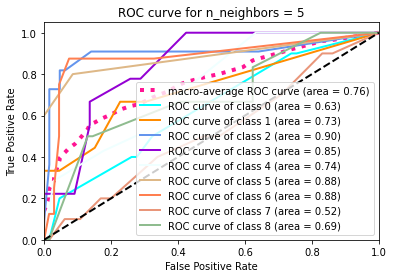

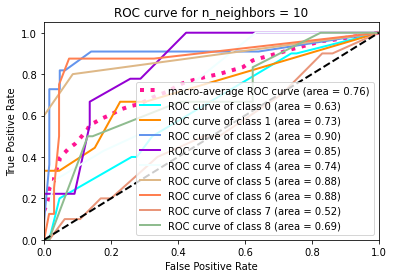

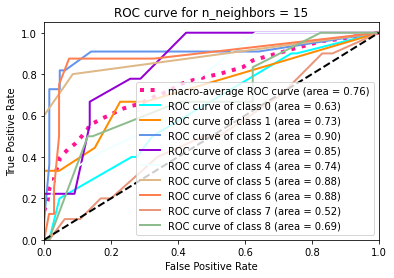

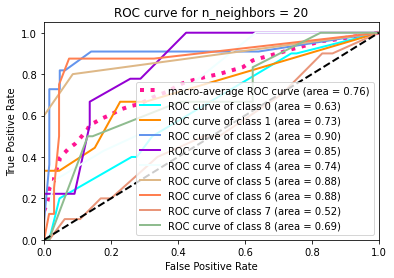

In [20]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import visualize_roc_auc_curve

for n_neighbors, fpr, tpr, roc_auc in zip(n_neighbors_arr, fprs, tprs, roc_aucs):
  title = f'ROC curve for n_neighbors = {str(n_neighbors)}'
  visualize_roc_auc_curve(title, fpr, tpr, roc_auc, len(np.unique(y_test)))